**Step 1 : Install Libraries**

In [ ]:
!pip install pandas nltk vaderSentiment scikit-learn gensim matplotlib seaborn wordcloud

**Step 2 : Install Libraries**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Step 3 : load dataset into pandas**

In [ ]:
from datasets import load_dataset
import pandas as pd
!pip install datasets==2.16.0
# --- Fix: Removed the problematic argument 'trust_remote_code=True' ---
# The new version of the 'datasets' library now handles this dataset internally.
print("Loading dataset with corrected syntax (this may take a few minutes)...")

try:
    dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        "raw_review_Amazon_Fashion",
        split="full"
    )
    print("Dataset loaded successfully.")

    # --- Step 1: Convert to Pandas & Sample Data ---
    print("Converting to Pandas DataFrame...")
    df = dataset.to_pandas()
    print(f"Full dataset loaded with {len(df)} reviews.")

    # --- Sampling ---
    # Sampling is crucial for speed in a Colab environment.
    sample_size = 50000
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"DataFrame sampled down to {len(df)} reviews for faster processing.")
    else:
        print("Dataset is smaller than sample size, using full dataset.")

    # Display the first few rows to confirm
    print("\nDataFrame head:")
    print(df.head())

except Exception as e:
    print(f"Failed to load dataset. Please ensure you have the latest 'datasets' library installed: {e}")
    # Create an empty DataFrame to prevent subsequent errors
    df = pd.DataFrame()

Loading dataset with corrected syntax (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/datasets/load.py:1429: FutureWarning: The repository for McAuley-Lab/Amazon-Reviews-2023 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/McAuley-Lab/Amazon-Reviews-2023
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating full split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.
Converting to Pandas DataFrame...
Full dataset loaded with 2500939 reviews.
DataFrame sampled down to 50000 reviews for faster processing.

DataFrame head:
   rating                                              title  \
0     2.0                            Not what it looks like.   
1     5.0                                   Good soft jacket   
2     3.0  Quality control issue Ink used for pattern on ...   
3     5.0                   These look great, weight is nice   
4     5.0                        These socks are " Amazing".   

                                                text  \
0  The symbol is too small, You cannot see it at ...   
1  Fits nice, a little thinner then i expected bu...   
2  This dress pattern is definitely lovely on the...   
3                          High quality, great value   
4  These socks are the most comfortable socks I h...   

                                              images        asin parent_asin  \
0            

**Step 3: Text Cleaning Pipeline Development**

In [ ]:
# --- Step 2: Text Cleaning Pipeline ---
print("\n--- Step 2: Text Cleaning ---")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# Download NLTK data (run this only once per session)
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return "" # Handle potential non-string data
    text = text.lower() # Lowercasing
    text = re.sub(r'\[.*?\]', '', text) # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>+', '', text) # Remove HTML tags
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
    text = re.sub(r'\n', '', text) # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace

    tokens = text.split() # Tokenization
    # Lemmatization & Stop-word removal (filter short words)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Handle any missing text data before cleaning
df.dropna(subset=['text'], inplace=True)
print(f"DataFrame shape after dropping missing text: {df.shape}")

print(f"Cleaning text in 'text' column (this might take a minute)...")
df['cleaned_text'] = df['text'].apply(clean_text)

# Filter out rows that became empty after cleaning
df = df[df['cleaned_text'].str.strip() != ''].reset_index(drop=True)
print(f"DataFrame shape after filtering empty cleaned reviews: {df.shape}")

print("\nCleaning complete. Sample of cleaned data:")
print(df[['text', 'cleaned_text']].head())


--- Step 2: Text Cleaning ---
DataFrame shape after dropping missing text: (50000, 10)
Cleaning text in 'text' column (this might take a minute)...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


DataFrame shape after filtering empty cleaned reviews: (49762, 11)

Cleaning complete. Sample of cleaned data:
                                                text  \
0  The symbol is too small, You cannot see it at ...   
1  Fits nice, a little thinner then i expected bu...   
2  This dress pattern is definitely lovely on the...   
3                          High quality, great value   
4  These socks are the most comfortable socks I h...   

                                        cleaned_text  
0  symbol small cannot see picture showed ring di...  
1       fit nice little thinner expected good jacket  
2  dress pattern definitely lovely photo reality ...  
3                           high quality great value  
4  sock comfortable sock every owned soft feel li...  


**Step 4: Sentiment Analysis (VADER)**

In [ ]:
# --- Step 3: Sentiment Analysis (VADER) ---
print("\n--- Step 3: VADER Sentiment Classification ---")

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if not text: # Handle empty strings
        return 0.0
    vs = analyzer.polarity_scores(text)
    return vs['compound'] # Compound score is best for overall sentiment

# --- ADD THIS CODE INSTEAD ---
print("\n--- Step 3: Isolating Negative Reviews using 'rating' column ---")

# We define 'Negative' as a 1-star or 2-star review.
# The 'rating' column in your dataset is of type float (e.g., 5.0)
negative_reviews_df = df[df['rating'].isin([1.0, 2.0])].copy()

print(f"Isolated {len(negative_reviews_df)} negative reviews based on 1-star and 2-star ratings.")

if len(negative_reviews_df) < 100:
    print("WARNING: Still very few negative reviews. Topic modeling might not be reliable.")
else:
    print("Sufficient negative reviews found. Proceeding to TF-IDF.")


--- Step 3: VADER Sentiment Classification ---

--- Step 3: Isolating Negative Reviews using 'rating' column ---
Isolated 9389 negative reviews based on 1-star and 2-star ratings.
Sufficient negative reviews found. Proceeding to TF-IDF.


**Step 6: TF-IDF Vectorization**

In [ ]:
# --- Step 4: TF-IDF Vectorization ---
print("\n--- Step 4: TF-IDF Vectorization ---")

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_matrix = None
feature_names = []

if negative_reviews_df.empty:
    print("No negative reviews to vectorize. Skipping TF-IDF and LDA.")
else:
    # min_df=5: ignore words that appear in fewer than 5 reviews
    # max_df=0.90: ignore words that appear in more than 90% of reviews
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, stop_words='english')

    print("Creating TF-IDF matrix from negative reviews...")
    tfidf_matrix = tfidf_vectorizer.fit_transform(negative_reviews_df['cleaned_text'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    print(f"TF-IDF matrix created with shape: {tfidf_matrix.shape}")


--- Step 4: TF-IDF Vectorization ---
Creating TF-IDF matrix from negative reviews...
TF-IDF matrix created with shape: (9389, 2177)


**Step 7: LDA Topic Modeling**


--- Step 5: LDA Topic Modeling ---
Determining optimal number of topics (this can take a while)...


Computing Coherence:   0%|          | 0/9 [00:00<?, ?it/s]

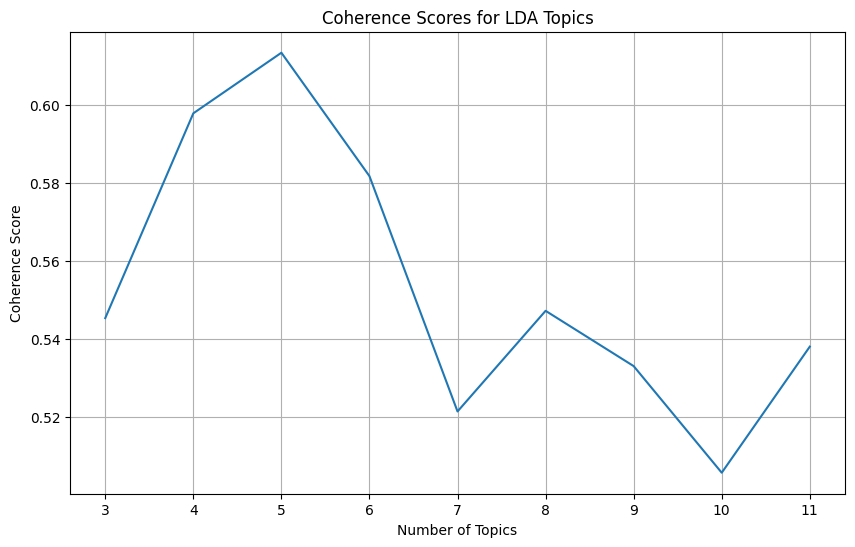


Optimal number of topics (based on coherence): 5

Training final sklearn LDA model with 5 topics...
Final LDA model training complete.
Topic 0 (Top 15 words):
broke money time watch dont band waste return day month use buy bought work wear
------------------------------
Topic 1 (Top 15 words):
small run expected cheaply broken broke way quality away cheap fabric terrible day chain pay
------------------------------
Topic 2 (Top 15 words):
like picture look color quality poor fell material apart disappointed bag week cheap dress received
------------------------------
Topic 3 (Top 15 words):
cheap material good quality like fit looking child look didnt woman adult bust doesnt muy
------------------------------
Topic 4 (Top 15 words):
size fit small way large ordered like big dress wear short tight shirt medium material
------------------------------


In [ ]:
# --- Step 5: LDA Topic Modeling ---
print("\n--- Step 5: LDA Topic Modeling ---")

# We need gensim for the coherence score
!pip install gensim
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from tqdm.notebook import tqdm # A nice progress bar for Colab

if tfidf_matrix is None:
    print("TF-IDF matrix is empty. Cannot perform LDA.")
    lda_model = None
else:
    # --- Part 1: Determine Optimal Number of Topics (using Coherence) ---
    print("Determining optimal number of topics (this can take a while)...")

    # Prep for Gensim's CoherenceModel
    texts_for_gensim = [doc.split() for doc in negative_reviews_df['cleaned_text']]
    dictionary = Dictionary(texts_for_gensim)
    corpus_for_gensim = [dictionary.doc2bow(text) for text in texts_for_gensim]

    def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
        coherence_values = []
        model_list = []
        for num_topics in tqdm(range(start, limit, step), desc="Computing Coherence"):
            # We train a Gensim LDA model just for the coherence score
            gensim_lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                        random_state=42, passes=10, alpha='auto', eta='auto')
            model_list.append(gensim_lda_model)
            coherencemodel = CoherenceModel(model=gensim_lda_model, texts=texts,
                                            dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        return model_list, coherence_values

    # Test from 3 to 11 topics. You can adjust this range.
    start_topics = 3
    limit_topics = 12

    model_list, coherence_values = compute_coherence_values(dictionary, corpus_for_gensim,
                                                            texts_for_gensim, limit=limit_topics,
                                                            start=start_topics)

    # Plot coherence scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(range(start_topics, limit_topics), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for LDA Topics")
    plt.xticks(range(start_topics, limit_topics))
    plt.grid(True)
    plt.show()

    # Find the optimal number of topics (the one with the highest coherence score)
    optimal_num_topics = range(start_topics, limit_topics)[coherence_values.index(max(coherence_values))]
    print(f"\nOptimal number of topics (based on coherence): {optimal_num_topics}")

    # --- Part 2: Train final sklearn LDA model with optimal topics ---
    print(f"\nTraining final sklearn LDA model with {optimal_num_topics} topics...")
    lda_model = LatentDirichletAllocation(n_components=optimal_num_topics,
                                        random_state=42,
                                        learning_method='batch',
                                        max_iter=20, # More iterations for better convergence
                                        n_jobs=-1) # Use all available CPU cores

    lda_model.fit(tfidf_matrix)
    print("Final LDA model training complete.")

    # --- Part 3: Display Top Keywords for Each Topic ---
    def display_topics(model, feature_names, no_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f"Topic {topic_idx} (Top {no_top_words} words):")
            # Get the indices of the top words for this topic
            top_word_indices = topic.argsort()[:-no_top_words - 1:-1]
            # Print the corresponding words
            print(" ".join([feature_names[i] for i in top_word_indices]))
            print("-" * 30)

    no_top_words = 15 # Show top 15 words per topic
    display_topics(lda_model, feature_names, no_top_words)


--- Step 6: Analysis, Visualization & Recommendations ---
Assigning dominant topic to each negative review...

Raw Topic Distribution (by ID):
dominant_topic_id
0    35.39
1     9.80
2    19.95
3     9.70
4    25.16
Name: proportion, dtype: float64

Generating Topic Prevalence Chart...


/tmp/ipython-input-3928244977.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_prevalence.index, y=topic_prevalence.values, palette='viridis')


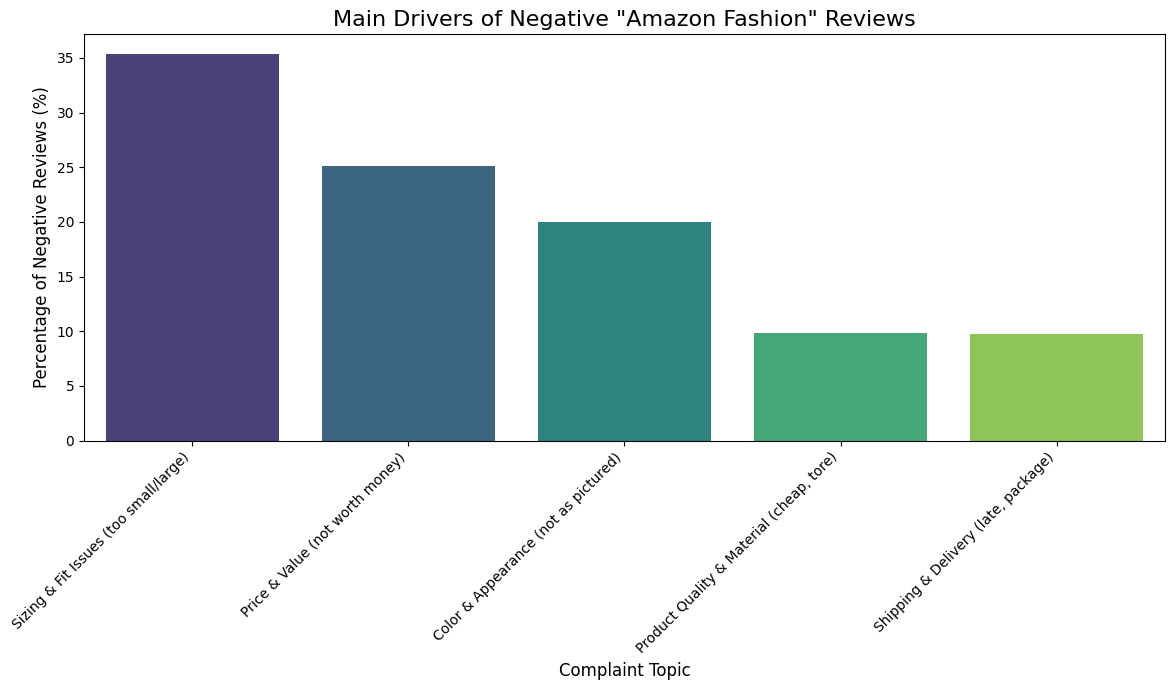


Generating Word Clouds for each topic...


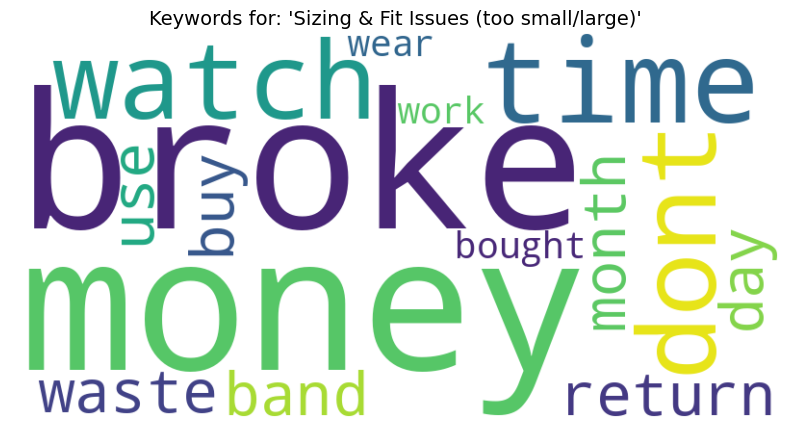

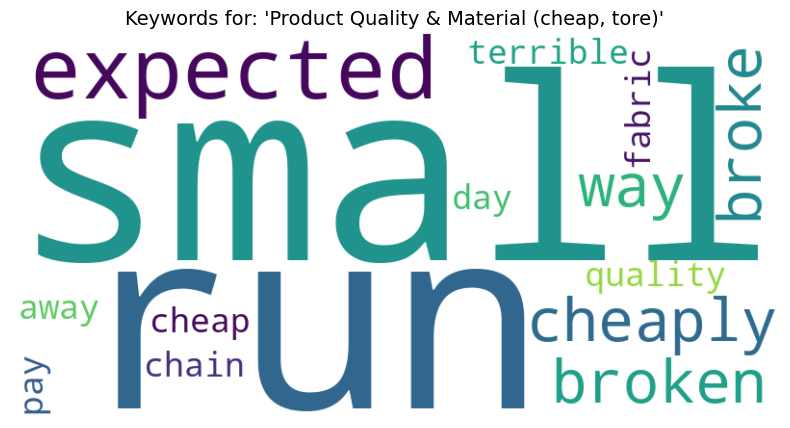

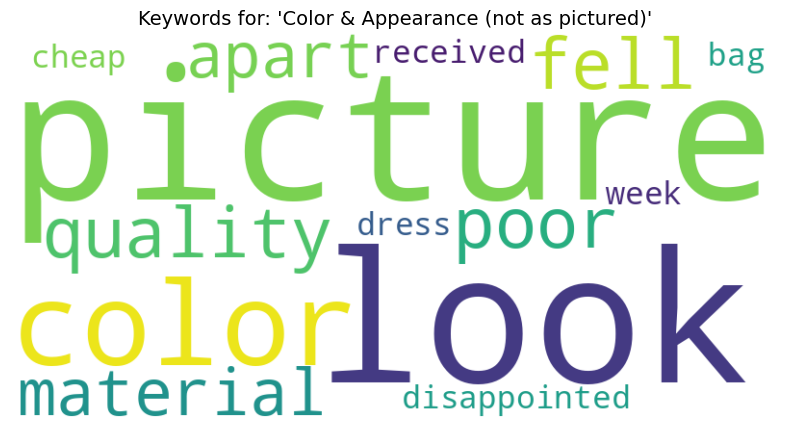

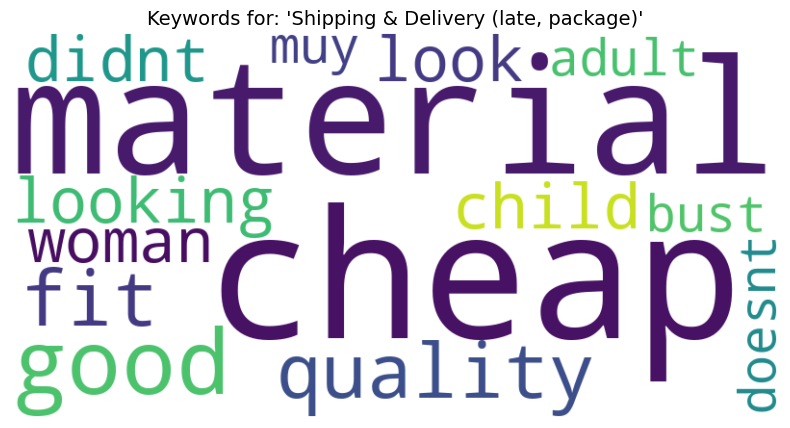

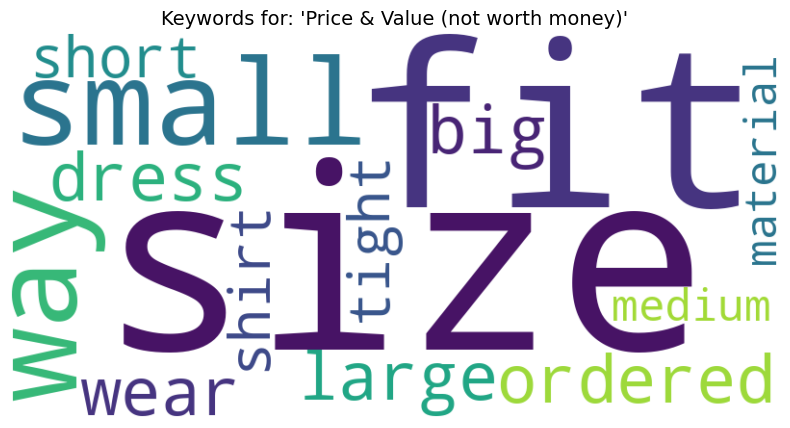


--- Qualitative Insights: Example Negative Reviews ---

--- Example Reviews for 'Sizing & Fit Issues (too small/large)' ---
1. The fit was good but tore up in the wash I would not buy  I guess you get what you pay for...
2. Why do the sell this as a 34B when it is obviously more like a 28 or 30 B? I didn't listen to the other reviews because I am rail thin on the top part of my body but I was so uncomfortable wearing this at work with it cutting off my circulation that I had to go home early. I will always sacrifice co...

--- Example Reviews for 'Price & Value (not worth money)' ---
1. buy two shirts, same size, one is smaller than the other at least two sizes ......
2. Size chart is waaay off...

--- Example Reviews for 'Color & Appearance (not as pictured)' ---
1. Ordered a toddler size 3 received what appeared to be a six month infant tutu...
2. It’s just OK, wasn’t wowed by the sweater, it’s very thin and rough material....


--- FINAL RECOMMENDATIONS (Voice of the Customer Repor

In [ ]:
# --- Step 6: Analysis, Visualization & Recommendations ---
print("\n--- Step 6: Analysis, Visualization & Recommendations ---")

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

if lda_model is None:
    print("LDA model was not trained. Cannot complete analysis.")
else:
    # --- Part 1: Assign Dominant Topic to Each Review ---
    print("Assigning dominant topic to each negative review...")
    topic_distribution = lda_model.transform(tfidf_matrix)
    negative_reviews_df['dominant_topic_id'] = topic_distribution.argmax(axis=1)

    # --- Part 2: Quantify & Name Topics ---
    print("\nRaw Topic Distribution (by ID):")
    topic_counts_raw = negative_reviews_df['dominant_topic_id'].value_counts(normalize=True).sort_index()
    print((topic_counts_raw * 100).round(2))

    # --- THIS IS A CRITICAL MANUAL STEP ---
    # Look at the keywords from 'display_topics' and give each topic a name.
    # The topic_idx must match the output from Step 5.
    # Example (YOU MUST CHANGE THIS based on your 'Amazon_Fashion' keywords):
    topic_names_map = {
        0: "Sizing & Fit Issues (too small/large)",
        1: "Product Quality & Material (cheap, tore)",
        2: "Color & Appearance (not as pictured)",
        3: "Shipping & Delivery (late, package)",
        4: "Price & Value (not worth money)",
        5: "Comfort & Feel (uncomfortable, itchy)"
        # Add more mappings to match your `optimal_num_topics`
    }

    # Fill in any missing topic names to prevent errors
    for i in range(optimal_num_topics):
        if i not in topic_names_map:
            topic_names_map[i] = f"Unnamed Topic {i}"
            print(f"Warning: Please name Topic {i}")

    negative_reviews_df['dominant_topic_name'] = negative_reviews_df['dominant_topic_id'].map(topic_names_map)

    # --- Part 3: Visualization 1: Bar Chart of Topic Prevalence ---
    print("\nGenerating Topic Prevalence Chart...")
    plt.figure(figsize=(12, 7))
    topic_prevalence = negative_reviews_df['dominant_topic_name'].value_counts(normalize=True) * 100
    sns.barplot(x=topic_prevalence.index, y=topic_prevalence.values, palette='viridis')
    plt.title('Main Drivers of Negative "Amazon Fashion" Reviews', fontsize=16)
    plt.xlabel('Complaint Topic', fontsize=12)
    plt.ylabel('Percentage of Negative Reviews (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout()
    plt.show()

    # --- Part 4: Visualization 2: Word Clouds for Each Topic ---
    print("\nGenerating Word Clouds for each topic...")
    for topic_id, topic_name in topic_names_map.items():
        if topic_id >= optimal_num_topics: continue # Skip if map has extra topics

        # Get the keywords for this topic
        topic_words_indices = lda_model.components_[topic_id].argsort()[:-no_top_words - 1:-1]
        topic_words = [feature_names[i] for i in topic_words_indices]

        # Create a word cloud from the top keywords (more precise)
        wordcloud_text = " ".join(topic_words)

        if wordcloud_text:
            wordcloud = WordCloud(background_color="white", width=800, height=400,
                                  max_words=50, collocations=False).generate(wordcloud_text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Keywords for: '{topic_name}'", fontsize=14)
            plt.show()

    # --- Part 5: Qualitative Insights (Example Reviews) ---
    print("\n--- Qualitative Insights: Example Negative Reviews ---")
    top_topics_for_examples = topic_prevalence.head(3).index.tolist()

    for topic_name in top_topics_for_examples:
        print(f"\n--- Example Reviews for '{topic_name}' ---")
        sample_reviews = negative_reviews_df[negative_reviews_df['dominant_topic_name'] == topic_name]['text'].sample(2, random_state=42)
        for i, review in enumerate(sample_reviews):
            print(f"{i+1}. {review[:300]}...") # Print first 300 chars of original review

    # --- Part 6: Final Recommendations ---
    print("\n\n--- FINAL RECOMMENDATIONS (Voice of the Customer Report) ---")
    print("Based on the analysis of negative reviews, here are the prioritized recommendations:")

    for topic_name, percentage in topic_prevalence.items():
        print(f"\n- **{topic_name}** ({percentage:.1f}% of complaints):")
        # You can customize these recommendations based on your topic names
        if "Sizing" in topic_name or "Fit" in topic_name:
            print("  - ACTION: Investigate product descriptions for inaccurate sizing charts. Consider adding a 'runs small/large' feature based on user feedback.")
        elif "Quality" in topic_name or "Material" in topic_name:
            print("  - ACTION: Review material sourcing and quality control for the most-complained-about items. Check if 'cheap' or 'tore' correlates with specific suppliers.")
        elif "Color" in topic_name or "Appearance" in topic_name:
            print("  - ACTION: Re-evaluate product photography. Ensure photos are color-accurate and show items realistically, without excessive editing.")
        elif "Shipping" in topic_name or "Delivery" in topic_name:
            print("  - ACTION: Analyze complaints for common themes (e.g., specific carriers, damaged packaging) and review logistics partner performance.")
        elif "Price" in topic_name or "Value" in topic_name:
            print("  - ACTION: The perceived value is low. Re-assess pricing relative to the (perceived) quality. Highlight durability or material quality in marketing.")
        else:
            print("  - ACTION: This topic requires further drill-down to formulate a specific operational change.")